# Theory & Applications for the correlation in pairwise differences

This notebook shows the recreation of plots showing the theoretical impact of time-stratified sampling 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import linregress
import pandas as pd

import sys
sys.path.append('../../src/')
from coal_cov import *
from seg_sites_covar import CorrSegSites
from draw_demography import *
from plot_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 3
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
main_figdir = '../../plots/two_locus_stats/'
supp_figdir = '../../plots/supp_figs/two_locus_stats/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

In [3]:
def estNe(t2s):
    """Given modern estimate of t2s calculate Ne."""
    return(np.mean(t2s)/2./2.)

def plot_bot_demo(ax, N0=1e4, T_bot=100, b=0.1, **kwargs):
    """Plot bottleneck demography."""
    xs = np.arange(0, int(10*T_bot))
    ns = np.repeat(N0, xs.size)
    ns[T_bot:] = N0*b
    ax.plot(xs,ns, **kwargs)
    
def corr_bl_2_corr_pi_kb(ta, corr_bl, theta=0.4, Ne=1e4):
    """Compute the correlation in pairwise diversity using the correlation in branch length."""
    coeff = 1. / (1. + (2 + (ta /2./Ne)/theta))
    corr_pi = coeff * corr_bl
    return(corr_pi, coeff)

def linear_appx_exp_slope(rho=1e-4):
    """Compute the expected slope """
    return(-rho/2. * (rho + 12.)/(rho**2 + 13*rho + 18.))
    
def intercept_appx(rho):
    """Approximatethe intecept in the constant sized case """
    return((rho + 18.)/(rho**2 + 13.*rho+ 18.))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 126.26it/s]


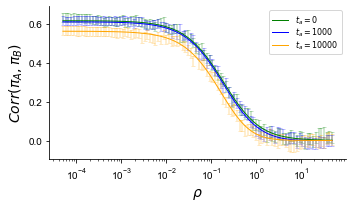

In [4]:
# Plotting just the first two plots
fig, axs = plt.subplots(1,1, figsize=(5,3), tight_layout=True)

# Plot Empirical Simulations  + overlayed theory 
colors = {0.0: 'green', 0.1:'blue', 1.0 : 'orange'}
tas = [0.0, 0.10,1.0]

#Paired correlation estimates
corr_s1_s2_df = pd.read_csv('../../results/two_loci/theory_mut_corr.csv')
for t in tqdm(tas):
    df = corr_s1_s2_df[(corr_s1_s2_df.ta == t) & (corr_s1_s2_df.nreps == 5000)] 
    rec_rate_mean = df.rec_rate
    corr_s1_s2 = df.corr_piApiB
    se_r = df.se_corr_piApiB
    axs.errorbar(rec_rate_mean/2, corr_s1_s2, yerr=2*se_r, 
                capsize=2, ls='none', alpha=0.25, color=colors[t])
    
    axs.plot(np.sort(rec_rate_mean)/2, TwoLocusTheoryConstant._corrSASB(4*np.sort(rec_rate_mean), ta=t/2, theta=4*0.4), 
            zorder=10, color=colors[t], lw=1, label=r'$t_a = %d$' % int(t*1e4))
axs.legend(fontsize=10, labelspacing=-0.0)
axs.set_xscale('log')
axs.set_xlabel(r'$\rho$', fontsize=14)    
axs.legend(fontsize=8, labelspacing=-0.0)
axs.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
debox(axs);

# axs.set_xlim(1e-5,1e-1)  
plt.tight_layout()
plt.savefig(main_figdir + 'corr_seg_sites_theory_sims_fixed.pdf', dpi=300, bbox_inches='tight')

## The effect of demography on the correlation in branch length

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.62it/s]


Ne (Constant-Size): 5069.94
Ne (Constant-Size): 10054.84
Ne (Constant-Size): 20080.01
Ne (Tennessen Model) : 6922.91
Ne (Browning Model): 2670.19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.23it/s]


Ne (Instant Growth 7): 168.13
Ne (Instant Growth 8): 183.60
Ne (Instant Growth 9): 243.28


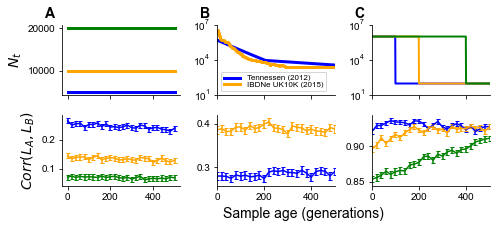

In [5]:
## ------ Figure of correlation in branch length in various demographies  ------- ##
fig, axs = plt.subplots(2,3, figsize=(7, 3), sharex='col')

# Part 1: Constant population size
ax3 = axs[0,0]; debox(ax3)
ax4 = axs[1,0]; debox(ax4)

# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# compute the asymptotic standard errors (Note - these are similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
    print("Ne (Constant-Size): %0.2f" % Ne_hat)
    
    ax3.plot(tas, np.repeat(n,tas.size), lw=3, color=colors[i])
    # Note - this is a fixed theta here ... 
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    rho = 2*Ne_hat*1e-4
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    ax4.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1


ax5 = axs[0,1]; debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'IBDNe UK10K (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e1,1e7)
ax5.set_xlim(0, 500)
ax5.legend(fontsize=8, labelspacing=-0.0)

ax6 = axs[1,1]; debox(ax6)

# Plot the Tennessen et al model...
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
mean_et2 = np.mean(cur_df.exp_bl)
Ne_hat = mean_et2/2./2.
print('Ne (Tennessen Model) : %0.2f' % Ne_hat)
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl, Ne=Ne_hat)
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])


# Plot the UK10K results
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
mean_et2 = np.mean(cur_df.exp_bl)
Ne_hat = mean_et2/2./2.
print('Ne (Browning Model): %0.2f' % Ne_hat)
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl, Ne=Ne_hat)
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])


ax7 = axs[0,2]; debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_ylim(1e1,1e7)
ax7.set_xlim(0,500)
    
ax8 = axs[1,2]; debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
    print("Ne (Instant Growth %d): %0.2f" % (x, Ne_hat))
    theta = 4 * Ne_hat * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl, Ne=Ne_hat)
    ax8.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1

    
# Labeling all of the axes
for (axi,lbl) in zip([axs[0,0], axs[0,1], axs[0,2]],['A','B','C']):
    axi.text(-0.06, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);


axs[0,0].set_ylabel(r'$N_t$', fontsize=14)
axs[1,0].set_ylabel(r'$Corr(L_A,L_B)$', fontsize=14)
plt.tight_layout()

fig.text(0.45, -0.025, r'Sample age (generations)', fontsize=14)
plt.savefig(main_figdir + 'full_demography.corr_branch_len.pdf', dpi=300, bbox_inches='tight')

In [6]:
# Checking the linear approximation for constant-size
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# Compute the asymptotic standard errors (Note - these are very similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in Ns:
    print("Ne = %d" % n)
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.

    # Note - this is a fixed theta here ...
    rho = 4*(2*cur_df.Ne.values[0])*1e-4
    print("Predicted Slope: %0.4f; Predicted Intercept: %0.4f"% (linear_appx_exp_slope(rho), intercept_appx(rho)))
    slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), cur_df.corr_bl)
    print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
    # Verify that the product of ta*rho << 1
    print("ta * rho: %0.4f" % (np.max(cur_df.ta)/(2.*n) * rho))
    print("") # empty line for style, becuase ... 

Ne = 5000
Predicted Slope: -0.3721; Predicted Intercept: 0.2558
Estimated Slope: -0.4289; Estimated Intercept: 0.2571; p-value: 0.000001
ta * rho: 0.2000

Ne = 10000
Predicted Slope: -0.4301; Predicted Intercept: 0.1398
Estimated Slope: -0.5194; Estimated Intercept: 0.1405; p-value: 0.000213
ta * rho: 0.2000

Ne = 20000
Predicted Slope: -0.4647; Predicted Intercept: 0.0705
Estimated Slope: -0.5267; Estimated Intercept: 0.0724; p-value: 0.001848
ta * rho: 0.2000



In [7]:
# Checking the linear approximation for constant-size
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# Compute the asymptotic standard errors (Note - these are very similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in Ns:
    print("Ne = %d" % n)
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.

    # Note - this is a fixed theta here ...
    rho = 4*(2*cur_df.Ne.values[0])*1e-4
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
#     print(coeff)
    print("Predicted Slope: %0.4f; Predicted Intercept: %0.4f"% (linear_appx_exp_slope(rho), intercept_appx(rho)))
    # NOTE: this doesn't make sense to compute becuase its not an approximation to the correlation in branch length 
    slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), corr_pi)
    print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
    # Verify that the product of ta*rho << 1
    print("ta * rho: %0.4f" % (np.max(cur_df.ta)/(2.*n) * rho))
    print("")

Ne = 5000
Predicted Slope: -0.3721; Predicted Intercept: 0.2558
Estimated Slope: -0.2058; Estimated Intercept: 0.0856; p-value: 0.000000
ta * rho: 0.2000

Ne = 10000
Predicted Slope: -0.4301; Predicted Intercept: 0.1398
Estimated Slope: -0.2078; Estimated Intercept: 0.0468; p-value: 0.000020
ta * rho: 0.2000

Ne = 20000
Predicted Slope: -0.4647; Predicted Intercept: 0.0705
Estimated Slope: -0.1937; Estimated Intercept: 0.0241; p-value: 0.000705
ta * rho: 0.2000



## The effect of demography on the correlation in pairwise differences

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.34it/s]


Ne = 5000 Constant Model
Estimated Slope: -0.2058; Estimated Intercept: 0.0856; p-value: 0.000000
Ne = 10000 Constant Model
Estimated Slope: -0.2078; Estimated Intercept: 0.0468; p-value: 0.000020
Ne = 20000 Constant Model
Estimated Slope: -0.1937; Estimated Intercept: 0.0241; p-value: 0.000705
Tennessen et al 2012 Model
Estimated Slope: 0.0438; Estimated Intercept: 0.0929; p-value: 0.319267
UK10K IBDNe Model
Estimated Slope: -0.4103; Estimated Intercept: 0.1300; p-value: 0.000000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.67it/s]


InstantGrowth7 Model
Estimated Slope: -677.1784; Estimated Intercept: 0.2803; p-value: 0.000000
InstantGrowth8 Model
Estimated Slope: -573.7824; Estimated Intercept: 0.2824; p-value: 0.000000
InstantGrowth9 Model
Estimated Slope: -411.2089; Estimated Intercept: 0.2745; p-value: 0.000000


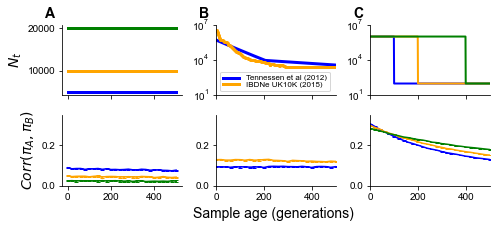

In [8]:
## ------ Testing figure  ------- ##
fig, axs = plt.subplots(2,3, figsize=(7, 3), sharex='col')

# Part 1: Constant population size
ax3 = axs[0,0]; debox(ax3)
ax4 = axs[1,0]; debox(ax4)

# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# compute the asymptotic standard errors (Note - these are similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    print("Ne = %d Constant Model" % n)
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    
    ax3.plot(tas, np.repeat(n,tas.size), lw=3, color=colors[i])
    # Note - this is a fixed theta here ... 
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), corr_pi)
    print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
    # Note - we linearly scale the standard error here ... 
    ax4.errorbar(cur_df.ta, corr_pi,  yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    i += 1


ax5 = axs[0,1]; debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen et al (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'IBDNe UK10K (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e1,1e7)
ax5.set_xlim(0, 500)
ax5.legend(fontsize=8, labelspacing=-0.0)


ax6 = axs[1,1]; debox(ax6)

# Plot the Tennessen et al model...
print("Tennessen et al 2012 Model")
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
mean_et2 = np.mean(cur_df.exp_bl)
# Ne_hat = mean_et2/2./2.
Ne_hat = cur_df.Ne_est.values[0]
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), corr_pi)
print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])

# Plot the UK10K results
print("UK10K IBDNe Model")
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
mean_et2 = np.mean(cur_df.exp_bl)
# Ne_hat = mean_et2/2./2.
Ne_hat = cur_df.Ne_est.values[0]
# Ne_hat = 1e4
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), corr_pi)
print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


ax7 = axs[0,2]; debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_ylim(1e1,1e7)
ax7.set_xlim(0,500)
    
ax8 = axs[1,2]; debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    print("InstantGrowth%d Model" % x)
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    mean_et2 = np.mean(cur_df.exp_bl)
#     Ne_hat = mean_et2/2./2.
    Ne_hat = cur_df.Ne_est.values[0]
    theta = 4 * Ne_hat * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), corr_pi)
    print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
    ax8.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    i += 1

    
    
# Labeling all of the axes
for (axi,lbl) in zip([axs[0,0], axs[0,1], axs[0,2]],['A','B','C']):
    axi.text(-0.06, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);


# Setting the y-limit to make things more comparable on bottom row
for x in axs[1,:]:
    x.set_ylim(0,0.35);
    
    
axs[0,0].set_ylabel(r'$N_t$', fontsize=14)
axs[1,0].set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
plt.tight_layout()

fig.text(0.55, -0.025, r'Sample age (generations)', ha='center', fontsize=14)
plt.savefig(main_figdir + 'full_demography.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')

## Comparing correlation in pairwise differences under two demographic models

In [9]:
test_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
test_df.head()

,scenario,N,ta,L,rec_rate_mean,rec_rate_se,corr_s1_s2,se_corr,seed,Ne
0,SerialConstant,200,0,1000,0.00001,1.549490e-09,0.226360,0.003080,42,10000
1,SerialConstant,200,0,1000,0.00002,2.102783e-09,0.198395,0.003099,42,10000
2,SerialConstant,200,0,1000,0.00003,2.398451e-09,0.158905,0.003122,42,10000
3,SerialConstant,200,0,1000,0.00004,2.606499e-09,0.126981,0.003137,42,10000
4,SerialConstant,200,0,1000,0.00005,2.734551e-09,0.122383,0.003139,42,10000


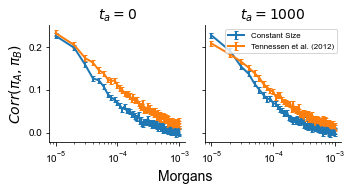

In [10]:

filt_df1 = test_df[(test_df.scenario == 'SerialConstant') & (test_df.ta == 0) & (test_df.seed == 42)]
filt_df2 = test_df[(test_df.scenario == 'TennessenEuropean') & (test_df.ta == 0) & (test_df.seed == 42)]

fig, ax = plt.subplots(1,2,figsize=(5,2.5), sharex=True, sharey=True)
ax[0].errorbar(filt_df1.rec_rate_mean, filt_df1.corr_s1_s2, 
            yerr=2*filt_df1.se_corr, capsize=2, lw=2, label=r'Constant Size')

ax[0].errorbar(filt_df2.rec_rate_mean, filt_df2.corr_s1_s2, 
            yerr=2*filt_df2.se_corr, capsize=2, lw=2, label=r'Tennessen et al. (2012)')
ax[0].set_xscale('log')
ax[0].set_title(r'$t_a = %d$' % 0, fontsize=14)

# Making the plot with new timepoints
filt_df1 = test_df[(test_df.scenario == 'SerialConstant')  & (test_df.ta == 1000) & (test_df.seed == 42)]
filt_df2 = test_df[(test_df.scenario == 'TennessenEuropean')  & (test_df.ta == 1000) & (test_df.seed == 42)]

ax[1].errorbar(filt_df1.rec_rate_mean, filt_df1.corr_s1_s2, 
            yerr=2*filt_df1.se_corr, capsize=2, lw=2, label=r'Constant Size')

ax[1].errorbar(filt_df2.rec_rate_mean, filt_df2.corr_s1_s2, 
            yerr=2*filt_df2.se_corr, capsize=2, lw=2, label=r'Tennessen et al. (2012)')

ax[1].set_title(r'$t_a = %d$' % 1000, fontsize=14)


# Plotting aesthetics 
debox(ax[0]); debox(ax[1]);
ax[1].legend(fontsize=8)

# Setting labels
ax[0].set_ylabel(r'$Corr(\pi_A,\pi_B)$',fontsize=14);
fig.text(0.45, -0.025, r'Morgans', fontsize=14);
plt.savefig(supp_figdir + 'demo_test_v_constant.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')